# Limpando Dados

## Sobre os dados
Neste notebook, usaremos dados de temperatura diária do [API do National Centers for Environmental Information (NCEI)](https://www.ncdc.noaa.gov/cdo-web/webservices/v2). Utilizaremos o conjunto de dados Global Historical Climatology Network - Daily (GHCND); veja a documentação [aqui](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf).

Esses dados foram coletados da estação do Aeroporto LaGuardia em Nova York para outubro de 2018. Contêm:
- a temperatura mínima diária (`TMIN`)
- a temperatura máxima diária (`TMAX`)
- a temperatura média diária (`TAVG`)

*Nota: O NCEI faz parte da National Oceanic and Atmospheric Administration (NOAA) e, como você pode ver na URL do API, esse recurso foi criado quando o NCEI era chamado de NCDC. Caso a URL desse recurso mude no futuro, você pode procurar por "API de clima NCEI" para encontrar a atualizada.*

Além disso, usaremos dados do mercado de ações do S&P 500 (obtidos usando o pacote [`stock_analysis`](https://github.com/stefmolin/stock-analysis))e dados de bitcoin de 2017 a 2018. Para a primeira edição, os dados de bitcoin foram coletados da CoinMarketCap usando o pacote `stock_analysis`; no entanto, mudanças no site levaram à necessidade de mudar a fonte de dados para Yahoo! Finance. Os dados de bitcoin coletados antes da mudança no site CoinMarketCap devem ser equivalentes aos dados históricos que podem ser vistos [nesta](https://coinmarketcap.com/currencies/bitcoin/historical-data/) página.

## Configuração
Precisamos importar `pandas` e ler os dados de temperatura para começar:

In [1]:
import pandas as pd

df = pd.read_csv('data/nyc_temperatures.csv')
df.head()

,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
1,2018-10-01T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2,2018-10-01T00:00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
3,2018-10-02T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
4,2018-10-02T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


## Renomeando Colunas
Começamos com as seguintes colunas:

In [2]:
df.columns

Index(['date', 'datatype', 'station', 'attributes', 'value'], dtype='object')

Queremos renomear a coluna `value` para indicar que ela contém a temperatura em Celsius e a coluna `attributes` para `flags`, já que cada valor na string delimitada por vírgulas é um flag diferente sobre a coleta de dados. Para esta tarefa, usamos o método `rename()` e passamos um dicionário mapeando os nomes das colunas para seus novos nomes. Passamos `inplace=True` para alterar nosso dataframe original em vez de obter um novo de volta:

In [3]:
df.rename(
    columns={
        'value': 'temp_C',
        'attributes': 'flags'
    }, inplace=True
)

Essas colunas foram renomeadas com sucesso:

In [4]:
df.columns

Index(['date', 'datatype', 'station', 'flags', 'temp_C'], dtype='object')

Também podemos realizar operações de string nos nomes das colunas com `rename()`:

In [5]:
df.rename(str.upper, axis='columns').columns

Index(['DATE', 'DATATYPE', 'STATION', 'FLAGS', 'TEMP_C'], dtype='object')

## Conversão de Tipo
A coluna `date` não está sendo armazenada atualmente como um `datetime`:

In [6]:
df.dtypes

date         object
datatype     object
station      object
flags        object
temp_C      float64
dtype: object

Vamos realizar a conversão com `pd.to_datetime()`:

In [8]:
df['date'] = pd.to_datetime(df.date)
df.dtypes

date        datetime64[ns]
datatype            object
station             object
flags               object
temp_C             float64
dtype: object

Agora obtemos informações úteis ao usar `describe()` nesta coluna:

In [10]:
df.date.describe()

count                     93
mean     2018-10-16 00:00:00
min      2018-10-01 00:00:00
25%      2018-10-08 00:00:00
50%      2018-10-16 00:00:00
75%      2018-10-24 00:00:00
max      2018-10-31 00:00:00
Name: date, dtype: object

Podemos usar `tz_localize()` em um objeto `DatetimeIndex` para converter para um fuso horário desejado:

In [11]:
pd.date_range(start='2018-10-25', periods=2, freq='D').tz_localize('America/Sao_Paulo')

DatetimeIndex(['2018-10-25 00:00:00-03:00', '2018-10-26 00:00:00-03:00'], dtype='datetime64[ns, America/Sao_Paulo]', freq=None)

Isso também funciona com objetos `Series`/`DataFrame` que têm um índice do tipo `DatetimeIndex`. Vamos ler o CSV novamente para este exemplo e definir a coluna `date` como o índice e armazená-la como `datetime`:

In [12]:
eastern = pd.read_csv(
    'data/nyc_temperatures.csv', index_col='date', parse_dates=True
).tz_localize('America/Sao_Paulo')
eastern.head()

,datatype,station,attributes,value
date,,,,
2018-10-01 00:00:00-03:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 00:00:00-03:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 00:00:00-03:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 00:00:00-03:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 00:00:00-03:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


Podemos usar `tz_convert()` para converter para outro fuso horário a partir daí. Se convertermos os datetimes do fuso horário Eastern para UTC, eles estarão agora às 3 da manhã, já que o `pandas` usará os deslocamentos para realizar a conversão:

In [13]:
eastern.tz_convert('UTC').head()

,datatype,station,attributes,value
date,,,,
2018-10-01 03:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 03:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 03:00:00+00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 03:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 03:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


Também podemos alterar o período do índice. Podemos mudar o período para ser mensal para facilitar a agregação posteriormente.

In [14]:
eastern.tz_localize(None).to_period('M').index

PeriodIndex(['2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-

Agora obtemos um objeto `PeriodIndex`, que podemos converter de volta para um objeto `DatetimeIndex` com `to_timestamp()`:

In [15]:
eastern.tz_localize(None).to_period('M').to_timestamp().index

DatetimeIndex(['2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
      

Podemos usar o método `assign()` para trabalhar com várias colunas ao mesmo tempo (ou criar novas). Como nossa coluna `date` já foi convertida, precisamos ler os dados novamente:

In [16]:
df = pd.read_csv('data/nyc_temperatures.csv').rename(
    columns={
        'value': 'temp_C',
        'attributes': 'flags'
    }
)

new_df = df.assign(
    date=pd.to_datetime(df.date),
    temp_F=(df.temp_C * 9/5) + 32
)
new_df.dtypes

date        datetime64[ns]
datatype            object
station             object
flags               object
temp_C             float64
temp_F             float64
dtype: object

A coluna `date` agora contém datetimes e a coluna `temp_F` foi adicionada:

In [17]:
new_df.head()

,date,datatype,station,flags,temp_C,temp_F
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,70.16
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,78.08
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,64.94
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,72.86
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,78.98


Também podemos usar `astype()` para realizar conversões. Vamos criar colunas da parte inteira das temperaturas em Celsius e Fahrenheit. Vamos usar funções lambda (introduzidas pela primeira vez no *Capítulo 2, Trabalhando com DataFrames Pandas*), para que possamos usar os valores criados na coluna `temp_F` para calcular a coluna `temp_F_whole`. É muito comum (e útil) usar funções lambda com `assign()`:

In [18]:
df = df.assign(
    date=lambda x: pd.to_datetime(x.date),
    temp_C_whole=lambda x: x.temp_C.astype('int'),
    temp_F=lambda x: (x.temp_C * 9/5) + 32,
    temp_F_whole=lambda x: x.temp_F.astype('int')
)

df.head()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


Criando categorias:

In [19]:
df_with_categories = df.assign(
    station=df.station.astype('category'),
    datatype=df.datatype.astype('category')
)
df_with_categories.dtypes

date            datetime64[ns]
datatype              category
station               category
flags                   object
temp_C                 float64
temp_C_whole             int64
temp_F                 float64
temp_F_whole             int64
dtype: object

In [20]:
df_with_categories.describe(include='category')

,datatype,station
count,93,93
unique,3,1
top,TAVG,GHCND:USW00014732
freq,31,93


Nossas categorias não têm uma ordem, mas isso é algo que o `pandas` suporta:

In [21]:
pd.Categorical(
    ['med', 'med', 'low', 'high'], 
    categories=['low', 'med', 'high'],
    ordered=True
)

['med', 'med', 'low', 'high']
Categories (3, object): ['low' < 'med' < 'high']

## Reordenando, reindexando e ordenando

Digamos que queremos encontrar os dias que alcançaram as temperaturas mais altas nos dados meteorológicos; podemos ordenar nossos valores pela coluna `temp_C`, com os maiores valores no topo para encontrar isso:

In [22]:
df[df.datatype == 'TMAX'].sort_values(by='temp_C', ascending=False).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
13,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
22,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


No entanto, isso não é perfeito porque temos alguns empates e eles não estão ordenados consistentemente. No primeiro empate entre o dia 7 e o dia 10, a data mais antiga vem primeiro, mas o oposto é verdadeiro no empate entre o dia 4 e o dia 2. Podemos usar outras colunas para resolver empates e especificar como ordenar cada uma com `ascending`. Vamos resolver empates usando a coluna de data e mostrar as datas mais antigas antes das mais recentes:

In [23]:
df[df.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True]).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
13,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
22,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


Observe que o índice estava desorganizado nos últimos 2 resultados. Aqui, nosso índice armazena apenas o número da linha nos dados originais, mas talvez não precisemos acompanhar essa informação. Nesse caso, podemos passar `ignore_index=True` para obter um novo índice após a ordenação:

In [24]:
df[df.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True], ignore_index=True).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
1,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
2,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
3,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
4,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
5,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
6,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
8,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
9,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


Quando queremos apenas os n maiores valores, em vez de ordenar todos os dados, podemos usar `nlargest()`:

In [27]:
df[df.datatype == 'TAVG'].nlargest(n=10, columns='temp_C')

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
27,2018-10-10,TAVG,GHCND:USW00014732,"H,,S,",23.8,23,74.84,74
30,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
18,2018-10-07,TAVG,GHCND:USW00014732,"H,,S,",22.8,22,73.04,73
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
6,2018-10-03,TAVG,GHCND:USW00014732,"H,,S,",21.8,21,71.24,71
24,2018-10-09,TAVG,GHCND:USW00014732,"H,,S,",21.8,21,71.24,71
9,2018-10-04,TAVG,GHCND:USW00014732,"H,,S,",21.3,21,70.34,70
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
21,2018-10-08,TAVG,GHCND:USW00014732,"H,,S,",20.9,20,69.62,69
12,2018-10-05,TAVG,GHCND:USW00014732,"H,,S,",20.3,20,68.54,68


Usamos `nsmallest()` para os n menores valores.

In [28]:
df.nsmallest(n=5, columns=['temp_C', 'date'])

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
65,2018-10-22,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
77,2018-10-26,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
62,2018-10-21,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
74,2018-10-25,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
53,2018-10-18,TMIN,GHCND:USW00014732,",,W,2400",6.7,6,44.06,44


O método `sample()` nos dará linhas (ou colunas com `axis=1`) de forma aleatória. Podemos fornecer uma semente (`random_state`) para tornar isso reproduzível. O índice após isso ficará desorganizado:

In [30]:
df.sample(5, random_state=0).index

Index([2, 30, 55, 16, 13], dtype='int64')

We can use `sort_index()` to order it again:

In [26]:
df.sample(5, random_state=0).sort_index().index

Int64Index([2, 13, 16, 30, 55], dtype='int64')

Podemos usar `sort_index()` para ordená-lo novamente:

In [31]:
df.sort_index(axis=1).head()

,datatype,date,flags,station,temp_C,temp_C_whole,temp_F,temp_F_whole
0,TAVG,2018-10-01,"H,,S,",GHCND:USW00014732,21.2,21,70.16,70
1,TMAX,2018-10-01,",,W,2400",GHCND:USW00014732,25.6,25,78.08,78
2,TMIN,2018-10-01,",,W,2400",GHCND:USW00014732,18.3,18,64.94,64
3,TAVG,2018-10-02,"H,,S,",GHCND:USW00014732,22.7,22,72.86,72
4,TMAX,2018-10-02,",,W,2400",GHCND:USW00014732,26.1,26,78.98,78


Isso pode facilitar a seleção com `loc` para muitas colunas:

In [32]:
df.sort_index(axis=1).head().loc[:,'temp_C':'temp_F_whole']

,temp_C,temp_C_whole,temp_F,temp_F_whole
0,21.2,21,70.16,70
1,25.6,25,78.08,78
2,18.3,18,64.94,64
3,22.7,22,72.86,72
4,26.1,26,78.98,78


Devemos ordenar o índice para comparar dois dataframes. Se o índice for diferente, mas os dados forem os mesmos, eles serão marcados como diferentes:

In [33]:
df.equals(df.sort_values(by='temp_C'))

False

Ordenar o índice resolve esse problema:

In [34]:
df.equals(df.sort_values(by='temp_C').sort_index())

True

Vamos definir a coluna `date` como nosso índice:

In [35]:
df.set_index('date', inplace=True)
df.head()

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


Agora que temos um índice do tipo `DatetimeIndex`, podemos fazer fatiamento e indexação por datas. Desde que forneçamos um formato de data que o pandas entenda, podemos obter os dados. Para selecionar todo o ano de 2018, simplesmente usamos `df.loc['2018']`, para o quarto trimestre de 2018 podemos usar `df.loc['2018-Q4']`, e para pegar outubro é tão simples quanto usar `df.loc['2018-10']`; esses podem também ser combinados para construir intervalos. Vamos pegar os dados de 11 de outubro de 2018 a 12 de outubro de 2018 (inclusive ambos os endpoints)—note que o uso de `loc[]` é opcional para intervalos:

In [40]:
df['2018-10-11':'2018-10-12']

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
2018-10-11,TMIN,GHCND:USW00014732,",,W,2400",21.7,21,71.06,71
2018-10-12,TAVG,GHCND:USW00014732,"H,,S,",18.3,18,64.94,64
2018-10-12,TMAX,GHCND:USW00014732,",,W,2400",22.2,22,71.96,71
2018-10-12,TMIN,GHCND:USW00014732,",,W,2400",12.2,12,53.96,53


Também podemos usar `reset_index()` para obter um índice novo e mover nosso índice atual para uma coluna para segurança. Isso é especialmente útil se tivermos dados, como a data, no índice que não queremos perder:

In [41]:
df['2018-10-11':'2018-10-12'].reset_index()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
1,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
2,2018-10-11,TMIN,GHCND:USW00014732,",,W,2400",21.7,21,71.06,71
3,2018-10-12,TAVG,GHCND:USW00014732,"H,,S,",18.3,18,64.94,64
4,2018-10-12,TMAX,GHCND:USW00014732,",,W,2400",22.2,22,71.96,71
5,2018-10-12,TMIN,GHCND:USW00014732,",,W,2400",12.2,12,53.96,53


A reindexação nos permite conformar nosso eixo para conter um conjunto dado de rótulos. Vamos usar os dados das ações do S&P 500 no arquivo `sp500.csv` para ver um exemplo disso. Note que temos dados apenas para dias de negociação (dias úteis, excluindo feriados):

In [42]:
sp = pd.read_csv(
    'data/sp500.csv', index_col='date', parse_dates=True
).drop(columns=['adj_close'])

sp.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3770530000,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3764890000,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3761820000,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3339890000,Friday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3217610000,Monday
2017-01-10,2279.270020,2265.270020,2269.719971,2268.899902,3638790000,Tuesday
2017-01-11,2275.320068,2260.830078,2268.600098,2275.320068,3620410000,Wednesday
2017-01-12,2271.780029,2254.250000,2271.139893,2270.439941,3462130000,Thursday
2017-01-13,2278.679932,2271.510010,2272.739990,2274.639893,3081270000,Friday


Se quisermos analisar o valor de uma carteira (grupo de ativos) que negocia em dias diferentes, precisamos lidar com a falta de correspondência no índice. O Bitcoin, por exemplo, negocia diariamente. Se somarmos todos os dados que temos para cada dia, obtemos o seguinte:

In [43]:
bitcoin = pd.read_csv(
    'data/bitcoin.csv', index_col='date', parse_dates=True
).drop(columns=['market_cap'])

# every day's closing price = S&P 500 close + Bitcoin close (same for other metrics)
portfolio = pd.concat([sp, bitcoin], sort=False).groupby(level='date').sum()

portfolio.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,1003.080000,958.700000,963.660000,998.330000,147775008,Sunday
2017-01-02,1031.390000,996.700000,998.620000,1021.750000,222184992,Monday
2017-01-03,3307.959883,3266.729883,3273.170068,3301.670078,3955698000,Tuesday
2017-01-04,3432.240068,3306.000098,3306.000098,3425.480000,4109835984,Wednesday
2017-01-05,3462.600000,3170.869951,3424.909932,3282.380000,4272019008,Thursday
2017-01-06,3328.910098,3148.000059,3285.379893,3179.179980,3691766000,Friday
2017-01-07,908.590000,823.560000,903.490000,908.590000,279550016,Saturday
2017-01-08,942.720000,887.250000,908.170000,911.200000,158715008,Sunday
2017-01-09,3189.179990,3148.709902,3186.830088,3171.729902,3359486992,Monday


Pode não ser imediatamente óbvio o que está errado com os dados anteriores, mas com uma visualização podemos facilmente ver o padrão cíclico de quedas nos dias em que o mercado de ações está fechado.

Agora precisamos importar o `matplotlib`:

In [44]:
import matplotlib.pyplot as plt # we use this module for plotting
from matplotlib.ticker import StrMethodFormatter # for formatting the axis

Agora podemos ver por que precisamos reindexar:

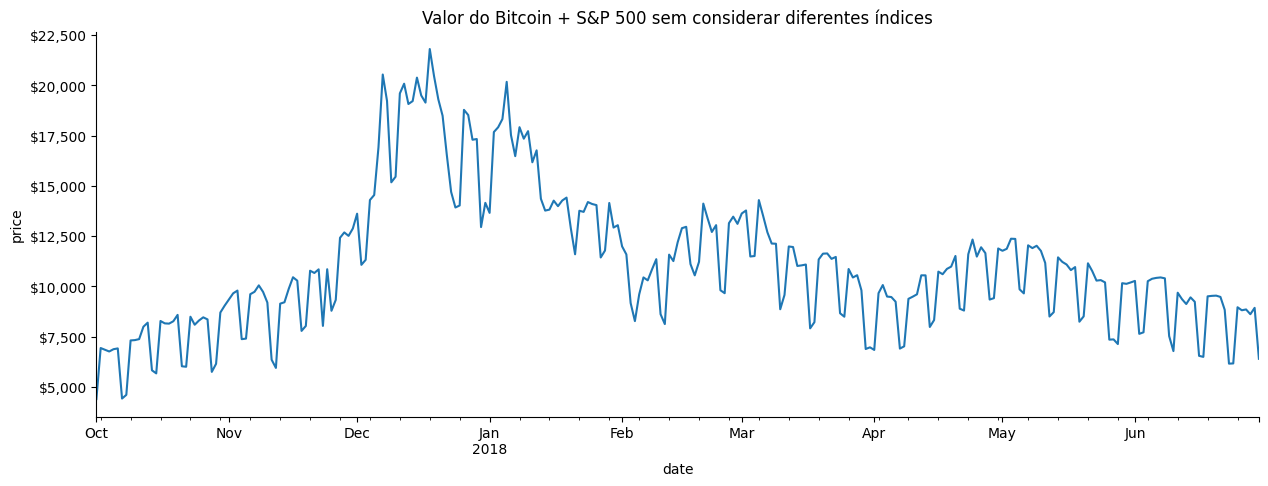

In [45]:
# plot the closing price from Q4 2017 through Q2 2018
ax = portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', figsize=(15, 5), legend=False,
    title='Valor do Bitcoin + S&P 500 sem considerar diferentes índices'
)

# formatting
ax.set_ylabel('price')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# show the plot
plt.show()

Precisamos alinhar o índice do S&P 500 para coincidir com o Bitcoin para resolver isso. Vamos usar o método `reindex()`, mas por padrão obteremos `NaN` para os valores para os quais não temos dados:

In [53]:
sp.head(30)

,high,low,open,close,volume
date,,,,,
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3770530000
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3764890000
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3761820000
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3339890000
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3217610000
2017-01-10,2279.270020,2265.270020,2269.719971,2268.899902,3638790000
2017-01-11,2275.320068,2260.830078,2268.600098,2275.320068,3620410000
2017-01-12,2271.780029,2254.250000,2271.139893,2270.439941,3462130000
2017-01-13,2278.679932,2271.510010,2272.739990,2274.639893,3081270000


In [54]:
bitcoin.head(30)

,open,high,low,close,volume
date,,,,,
2017-01-01,963.66,1003.08,958.70,998.33,147775008
2017-01-02,998.62,1031.39,996.70,1021.75,222184992
2017-01-03,1021.60,1044.08,1021.60,1043.84,185168000
2017-01-04,1044.40,1159.42,1044.40,1154.73,344945984
2017-01-05,1156.73,1191.10,910.42,1013.38,510199008
2017-01-06,1014.24,1046.81,883.94,902.20,351876000
2017-01-07,903.49,908.59,823.56,908.59,279550016
2017-01-08,908.17,942.72,887.25,911.20,158715008
2017-01-09,913.24,913.69,879.81,902.83,141876992


In [46]:
sp.reindex(bitcoin.index).head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-02,NaN,NaN,NaN,NaN,NaN,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,NaN,NaN,NaN,NaN,NaN,Saturday
2017-01-08,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


Agora temos linhas para todos os dias do ano, mas todos os fins de semana e feriados têm valores `NaN`. Para resolver isso, podemos especificar como lidar com os valores ausentes usando o argumento `method`. Neste caso, queremos preencher para frente (forward-fill), o que colocará os valores dos fins de semana e feriados como o valor que tiveram na sexta-feira (ou final da semana de negociação) anterior:

In [47]:
sp.reindex(bitcoin.index, method='ffill').head(10)\
    .assign(day_of_week=lambda x: x.index.day_name())

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-02,NaN,NaN,NaN,NaN,NaN,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Saturday
2017-01-08,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


Para isolar as mudanças que estão ocorrendo com o preenchimento para frente, podemos usar o método `compare()`. Ele nos mostra os valores que diferem entre dataframes identicamente rotulados (mesmos nomes e mesmas colunas). Aqui, podemos ver que apenas fins de semana e feriados (segunda-feira, 16 de janeiro de 2017 foi o Dia de Martin Luther King) têm valores preenchidos para frente. Observe que dias consecutivos têm os mesmos valores.

In [48]:
sp.reindex(bitcoin.index)\
    .compare(sp.reindex(bitcoin.index, method='ffill'))\
    .head(10).assign(day_of_week=lambda x: x.index.day_name())

high               low              open              close  \
           self        other self        other self        other  self   
date                                                                     
2017-01-07  NaN  2282.100098  NaN  2264.060059  NaN  2271.139893   NaN   
2017-01-08  NaN  2282.100098  NaN  2264.060059  NaN  2271.139893   NaN   
2017-01-14  NaN  2278.679932  NaN  2271.510010  NaN  2272.739990   NaN   
2017-01-15  NaN  2278.679932  NaN  2271.510010  NaN  2272.739990   NaN   
2017-01-16  NaN  2278.679932  NaN  2271.510010  NaN  2272.739990   NaN   
2017-01-21  NaN  2276.959961  NaN  2265.010010  NaN  2269.959961   NaN   
2017-01-22  NaN  2276.959961  NaN  2265.010010  NaN  2269.959961   NaN   
2017-01-28  NaN  2299.020020  NaN  2291.620117  NaN  2299.020020   NaN   
2017-01-29  NaN  2299.020020  NaN  2291.620117  NaN  2299.020020   NaN   
2017-02-04  NaN  2298.310059  NaN  2287.879883  NaN  2288.540039   NaN   

                        volume               day_of_week  
                  other   self         other              
date                                                      
2017-01-07  2276.979980    NaN  3.339890e+09    Saturday  
2017-01-08  2276.979980    NaN  3.339890e+09      Sunday  
2017-01-14  2274.639893    NaN  3.081270e+09    Saturday  
2017-01-15  2274.639893    NaN  3.081270e+09      Sunday  
2017-01-16  2274.639893    NaN  3.081270e+09      Monday  
2017-01-21  2271.310059    NaN  3.524970e+09    Saturday  
2017-01-22  2271.310059    NaN  3.524970e+09      Sunday  
2017-01-28  2294.689941    NaN  3.135890e+09    Saturday  
2017-01-29  2294.689941    NaN  3.135890e+09      Sunday  
2017-02-04  2297.419922    NaN  3.597970e+09    Saturday

Isso não é perfeito, porém. Provavelmente queremos 0 para o volume negociado e usar o preço de fechamento para preencher o preço de abertura, máximo, mínimo e fechamento nos dias em que o mercado está fechado:

In [55]:
import numpy as np

sp_reindexed = sp.reindex(bitcoin.index).assign(
    volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
    close=lambda x: x.close.fillna(method='ffill'), # carry this forward
    # take the closing price if these aren't available
    open=lambda x: np.where(x.open.isnull(), x.close, x.open),
    high=lambda x: np.where(x.high.isnull(), x.close, x.high),
    low=lambda x: np.where(x.low.isnull(), x.close, x.low)
)
sp_reindexed.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

/var/folders/14/lp737qrd6mng398vsjx9zwqw0000gn/T/ipykernel_601/1545621913.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close=lambda x: x.close.fillna(method='ffill'), # carry this forward


,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,0.000000e+00,Sunday
2017-01-02,NaN,NaN,NaN,NaN,0.000000e+00,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,2276.979980,2276.979980,2276.979980,2276.979980,0.000000e+00,Saturday
2017-01-08,2276.979980,2276.979980,2276.979980,2276.979980,0.000000e+00,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


Se criarmos uma visualização comparando os dados reindexados com a primeira tentativa, veremos como o reindexamento ajudou a manter o valor dos ativos quando o mercado estava fechado:

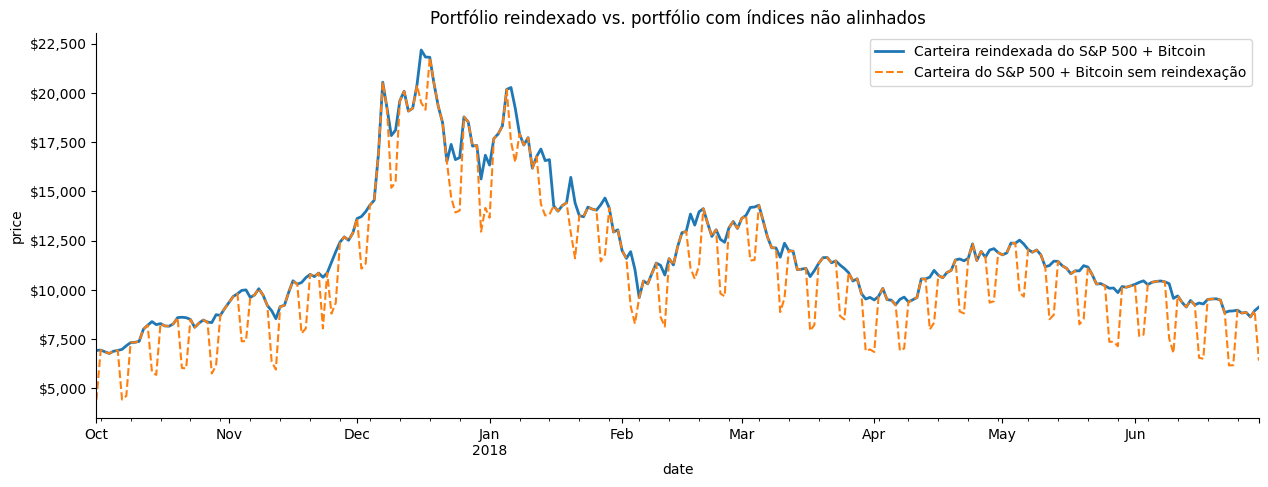

In [56]:
# every day's closing price = S&P 500 close adjusted for market closure + Bitcoin close (same for other metrics)
fixed_portfolio = sp_reindexed + bitcoin

# plot the reindexed portfolio's closing price from Q4 2017 through Q2 2018
ax = fixed_portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', label='Carteira reindexada do S&P 500 + Bitcoin', figsize=(15, 5), linewidth=2, 
    title='Portfólio reindexado vs. portfólio com índices não alinhados'
)

# add line for original portfolio for comparison
portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', ax=ax, linestyle='--', label='Carteira do S&P 500 + Bitcoin sem reindexação'
)

# formatting
ax.set_ylabel('price')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# show the plot
plt.show()

<hr>
<div>
    <a href="./2-using_the_weather_api.ipynb">
        <button>&#8592; Previous Notebook</button>
    </a>
    <a href="./4-reshaping_data.ipynb">
        <button style="float: right;">Next Notebook &#8594;</button>
    </a>
</div>
<hr>